<a href="https://colab.research.google.com/github/heyad/Teaching/blob/master/CV/Lab05U.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN and Transfor Learning


In this lab, you will build CNN-based models for classifying medical images. More specifically, you will build models to assist doctors in diagnosing pneumonia from x-ray images of the chest and lung. Upon completion of this document you will be able to:

* Load, explore, and preprocess a set of images from local directory into memory
* Build, train, and evaluate CNN models 
* Be familiar with [Image Data Generator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) and data augmentation 
* Use transfer learning for medical image classification (first using pre-trained models, and then you will learn how to fine-tune these models).

Some of the code here has been adapted from [Kaggle](www.kaggle.com)



## Build your own CNN

In this part, you will build your own CNN and train the model from scratch. First, you will load and explore the data. This will then be followed by building the CNN model and training it, and finally you will evaluate the model's performance on the testing set. 

In [2]:
# import the required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, AveragePooling2D,Flatten, Dense, Conv2D,MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

### Load and Explore Data

It is assumed that you have downloaded the dataset from Kaggle. You can obtain the dataset from the following link [https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). You need to have an account on Kaggle or simply use your gmail to log in. Once downloaded and extracted from the archive file, you need to change **main_direction_path** below to your local path. You can see the PDF tutorial for more details. Alternatively, you can simply load the data direct from Kaggle using its API. Various tutorials can show you how to do this e.g. [This link](https://www.kaggle.com/general/74235. Assuming that you downloaded the dataset into your gdrive, then the first step is to set the path and mount your drive: 

* First, mount the drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


* You can uncomment the code below if the file is a zip file

In [4]:
import zipfile

#!unzip -u "/content/gdrive/MyDrive/Data/Input.zip" -d "/content/gdrive/MyDrive/Data/Input"

In [5]:
# check the folders in your gdrive
!ls /content/gdrive/MyDrive/Data/Input

Input  trainu  val


In [6]:
# data stored in the local drive 
main_dirction_path = '/content/gdrive/MyDrive/Data/Input/Input/chest_xray/'
print(os.listdir(main_dirction_path))


['val', 'test', 'train']


You will notice that you have three subfolders in your main directory: train, test, and validation. These will be used for building and evaluating your model's performance. In addition, in each of these folders, you will have two subfolders **NORMAL** for non-infected patients, and **PNEUMONIA** folder (the positive class, patients with PNEUMONIA) as can be seen below:

In [7]:
# path for train/ test and validate folders
train_folder_path = main_dirction_path + '/train/'
test_folder_path = main_dirction_path + '/test/'
val_folder_path = main_dirction_path + '/val/'


Define Labels that will be used for classifications, as well as common parameters 

In [8]:
labels = os.listdir(train_folder_path)
img_size = 112 # 
batch_size = 16
n_epochs = 25 
labels

['NORMAL', 'PNEUMONIA']

The path's variables below point to the negative and positive instances of the training and testing sets (folders). We will use these to check the class distribution in our dataset. In other words, how many positive and negative instances are available. Recall, a hugely imbalanced dataset can lead to biased results. 

In [9]:
train_n_path = train_folder_path+'/NORMAL/'
train_p_path = train_folder_path+'/PNEUMONIA/'

test_n_path = test_folder_path+'/NORMAL/'
test_p_path = test_folder_path+'/PNEUMONIA/'

In [10]:
print(f'Number of normal images is {len(os.listdir(train_n_path))}') #length of normal training images
print(f'Number of postive images is {len(os.listdir(train_p_path))}') #length of pneumonia training images 
print(f'Total training images is  {len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))}')

Number of normal images is 1341
Number of postive images is 3875
Total training images is  5216


You can also check the number of images in the testing director

In [11]:
print(f'Number of normal images is {len(os.listdir(test_n_path))}') 
print(f'Number of positive images is {len(os.listdir(test_p_path))}') 
print(f'Total training images is {len(os.listdir(test_n_path)) + len(os.listdir(test_p_path))}') 

Number of normal images is 234
Number of positive images is 390
Total training images is 624


Lets create a function to load the images and extract the labels according to the folder that contain the images. You will notice that the sizes of the images are not the same. Recall, for a CNN or other models, we need to set all images to the same size (img_size)

In [12]:

def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

### Validation Set

Now, we load the training set, but we need to split it into train and validation, this is simply because the original val set in this dataset is relatively small:

In [13]:
train = get_training_data(train_folder_path)
temp = np.random.permutation(train) # Shuffle the data
train_size = 0.8 # Sets the split ratio

# Assigns 80% to training array and 20% to validation set
train, val = temp[:(int(train_size*len(temp)))], temp[int(train_size*len(temp)):]

In [14]:
# Load the datasets 

test = get_training_data(test_folder_path)


In [15]:
print(f'The shape of the training set is {train.shape}') 
print(f'The shape of the test set is {test.shape}') 
print(f'The shape of the val set is {val.shape}') 


The shape of the training set is (4172, 2)
The shape of the test set is (624, 2)
The shape of the val set is (1044, 2)


Notice that the sets above are of type numpy array (2 dimensional). You can check this using ```type(val)```



* Lets show the class distribution in the training set (0 denotes a normal image, while 1 denotes a pneumonia)

<AxesSubplot:ylabel='count'>

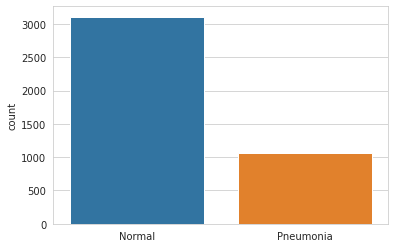

In [16]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('whitegrid')
sns.countplot(l)  

<AxesSubplot:ylabel='count'>

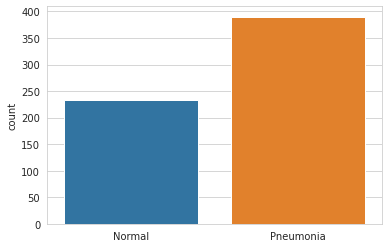

In [41]:
# for testing set
l = []
for i in test:
  if(i[1] == 0):
     l.append("Normal")
  else:
    l.append("Pneumonia")
sns.set_style('whitegrid')
sns.countplot(l)

<AxesSubplot:ylabel='count'>

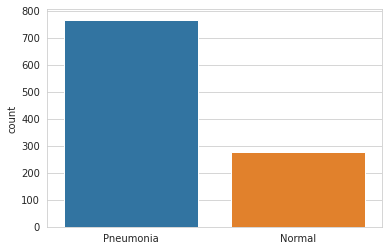

In [18]:
# and validation set
l = []
for i in val:
  if(i[1] == 0):
     l.append("Normal")
  else:
    l.append("Pneumonia")
sns.set_style('whitegrid')
sns.countplot(l)

Below is a function to show arbitray number of normal or pneumonia images subjecto the arguments passed. 

In [42]:
def show_sample_images (number, normal=True):
    plt.figure(figsize=(12,12))
    if normal == True:
        for n in range(number):
            normal_img = os.listdir(train_n_path)[n]
            normal_img_address = train_n_path+normal_img
            normal_load = Image.open(normal_img_address)
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(normal_load, cmap ='gray')
            plt.title("NORMAL")
    else:
        for n in range(number):
            pneumonia_img =  os.listdir(train_p_path)[n]
            pneumonia_img_address = train_p_path+pneumonia_img
            pneumonia_load = Image.open(pneumonia_img_address)
            #cast nrows to integer
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(pneumonia_load, cmap ='gray')
            plt.title("PNEUMONIA")
      
    plt.axis("off")      

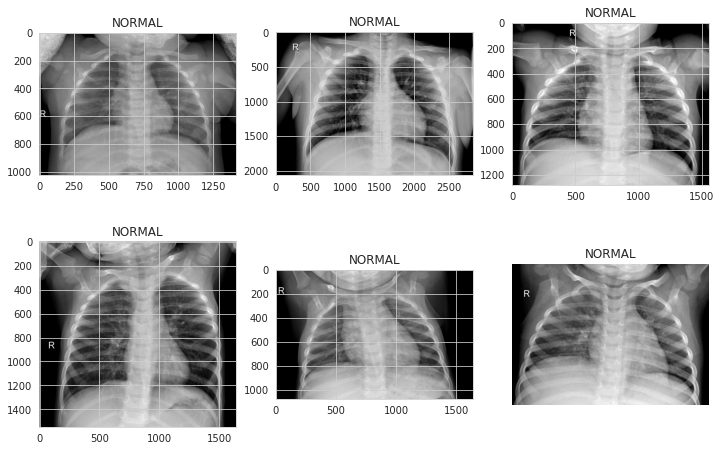

In [43]:
# Show normal images
numberImg= 6
show_sample_images(numberImg)

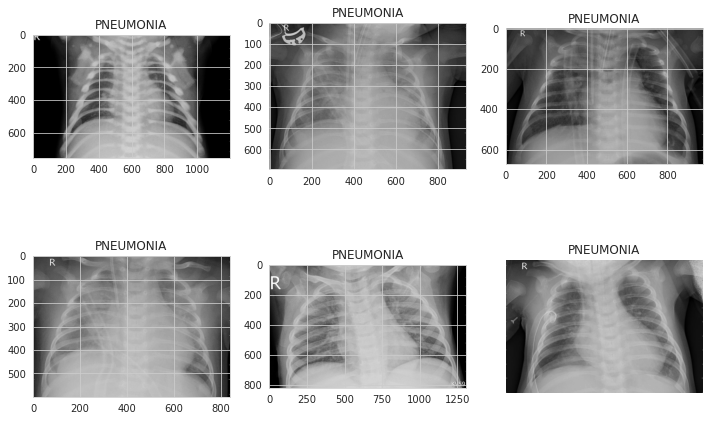

In [44]:
# show pneumonia images 
show_sample_images(6,False)

Let's apply histogram equalization to improve images contrast (better visualisation). More about histogram equalization can  be found at [https://homepages.inf.ed.ac.uk/rbf/HIPR2/histeq.htm](https://homepages.inf.ed.ac.uk/rbf/HIPR2/histeq.htm)  and also documentation can be found here (how to implement it) [here](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist). As you can see below, this gives a better visualisation of the images:

In [45]:
#!pip install scikit-image
from skimage import exposure

In [46]:
def equlize_hist_ (image):
  _image = np.asarray(image)
  image_eq = exposure.equalize_hist(_image)
  return image_eq


In [47]:
def expose_imgae(Normal=True):
    if Normal==True:
        # Choose normal random image: generate random number between 1 and  the number of normal images in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_n_path))) 
        # image file name 
        img_expose_name = os.listdir(train_n_path)[random_img_ind]

        # path to the image
        img_expose_address = train_n_path+img_expose_name

        # load mage 
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('Normal')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('Normal after HE')
        plt.axis("off") 
    else:
        # Choose normal random image: generate random number between 1 and  the number of normal images in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_p_path))) 
        # image file name 
        img_expose_name = os.listdir(train_p_path)[random_img_ind]

        # path to the image
        img_expose_address = train_p_path+img_expose_name

        # load mage 
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('Pneumonia')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('Pneumonia after HE')
        plt.axis("off") 

       

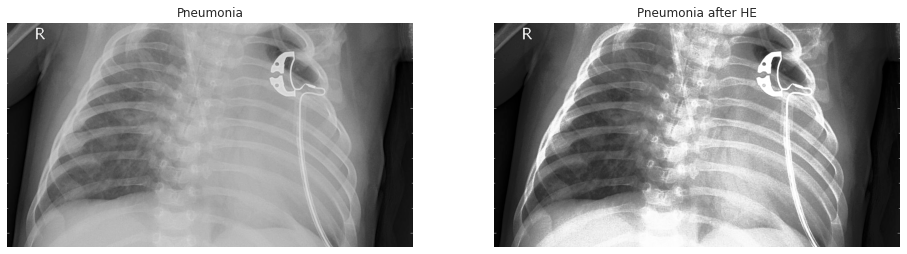

In [48]:
# expose_image() will show random normal image
expose_imgae(False)


### Build CNN Model

First step, we want to arrange the data in different constructs (x_train, y_train, x_test, y_test, x_val,y_val), etc...):





In [49]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [53]:
print(f'Number of images in the training set is {len(x_train)}')



Number of images in the training set is 4172


In [50]:
# Normalise the data 

x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

Resize the arrays for deep learning 

In [51]:
# resize data for deep learning (img_size above is set to 244 by 244)
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

#### Image Data Generator

It should be noted that [Kerass ImageDatGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) can be used to perform data augmentation (see lecture notes for more on data augmentation). Recall, data augmentation help improve the performance of the model by generating more data via applying a geometric transformation (e.g. translation, rotation, scaling, shearing, etc...) to existing data/ images. Below is the code to use ImageDataGenerator to augment your dataset. Notice that in this tutorial we are not using it, but applying augmentation should improve performance. 


In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

datagen = ImageDataGenerator(

      featurewise_center=False, 
      samplewise_center=False, 
      featurewise_std_normalization=False, 
      samplewise_std_normalization=False, 
      zca_whitening=False, 
      rotation_range = 30, 
      zoom_range = 0.2, 
      
      width_shift_range = 0.1, 
      height_shift_range = 0.1, 
      horizontal_flip = True, 
      vertical_flip=False) 

datagen.fit(x_train)




#### CNN Model

The code below defines a CNN model. Notice, that this is almost similar to most of the architecture we discussed in the lectures (e.g. Conv layers, followed by pooling and drop out, repeated a few times). A couploe of notes about the code below:

1. Notice the **BatchNormalization** layer that is added to the model. This is often used to speed up the training process and make it more stable. It does so by normalizing the inputs from hidden layers, you can find more details about batch normalization at this [https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338)

2. The **Droput** layer: is used to prevent overfitting of the model. It does this by setting some input units to 0 during the training process (e.g. switching off some neurons in the network)

In [31]:
# Model setup
model = Sequential()
model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(128, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Conv2D(256, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(
              optimizer = 'rmsprop', loss = 'binary_crossentropy', 
              metrics = ['accuracy']
              )


In [55]:
# model summary (see the number of trainable parameters)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 56, 56, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 64)       2

Running the model: One thing, we need to add before running the model is to account for the class imbalance in our dataset. Image Data Generator has a parameter for setting class weight, that can help address the imbalance story. More about this can be found here [https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights). In summary, we want to give heavier weight for minority class instances. To compute the class weight for each of our classes (positive/ normal, and pneumonia), we follow this formula:


$$weight_0 = \frac{1}{Neg} \times \frac{total}{2}$$
$$Weight_1 = \frac{1}{Pos} \times \frac{total}{2}$$

In [56]:
total = len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))
neg = len(os.listdir(train_n_path))
pos = len(os.listdir(train_p_path))

weight_for_0 = 1 /neg * (total/2.0)
weight_for_1 = 1/pos *(total/2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 1.9448173005219984, 1: 0.6730322580645162}

In [57]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)

In [59]:
# Start training the model
history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size), 
                    epochs = n_epochs, validation_data = datagen.flow(x_val, y_val), 
                    callbacks = [learning_rate_reduction], class_weight = class_weight)

Epoch 1/25
261/261 [==============================] - 18s 69ms/step - loss: 0.1168 - accuracy: 0.9600 - val_loss: 0.1587 - val_accuracy: 0.9435 - lr: 1.0000e-06
Epoch 2/25
261/261 [==============================] - 18s 67ms/step - loss: 0.1302 - accuracy: 0.9585 - val_loss: 0.1532 - val_accuracy: 0.9397 - lr: 1.0000e-06
Epoch 3/25
261/261 [==============================] - 17s 67ms/step - loss: 0.1283 - accuracy: 0.9597 - val_loss: 0.1620 - val_accuracy: 0.9416 - lr: 1.0000e-06
Epoch 4/25
261/261 [==============================] - 18s 67ms/step - loss: 0.1359 - accuracy: 0.9616 - val_loss: 0.1519 - val_accuracy: 0.9444 - lr: 1.0000e-06
Epoch 5/25
261/261 [==============================] - 18s 68ms/step - loss: 0.1207 - accuracy: 0.9616 - val_loss: 0.1533 - val_accuracy: 0.9416 - lr: 1.0000e-06
Epoch 6/25
261/261 [==============================] - 19s 72ms/step - loss: 0.1069 - accuracy: 0.9602 - val_loss: 0.1548 - val_accuracy: 0.9473 - lr: 1.0000e-06
Epoch 7/25
261/261 [==============

#### Analyse Results

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [ ]:
losses[['accuracy','val_accuracy']].plot()
    

Check the testing accuracy/ loss

In [62]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 10ms/step - loss: 0.2706 - accuracy: 0.9054
Loss of the model is -  0.2706117331981659
20/20 [==============================] - 0s 10ms/step - loss: 0.2706 - accuracy: 0.9054
Accuracy of the model is -  90.54487347602844 %


Save the model and make some predictions:

In [63]:
from tensorflow.keras.models import load_model
#model.save('CNN_PNEUMONIA.h5') # 
#cnn_model = load_model("./CNN_PNEUMONIA.h5")
predictions=model.predict(x_test) 
pred_labels= np.where(predictions>0.5, 1, 0)


20/20 [==============================] - 0s 9ms/step


Confusion Matrix: recall that $$ precision=\frac{TP}{TP+FP}$$ and $$recall=\frac{TP}{TP+FN}$$

In [64]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, pred_labels, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.83      0.94      0.88       234
   Normal (Class 1)       0.96      0.88      0.92       390

           accuracy                           0.91       624
          macro avg       0.90      0.91      0.90       624
       weighted avg       0.91      0.91      0.91       624



Plot confusion matrix

<AxesSubplot:>

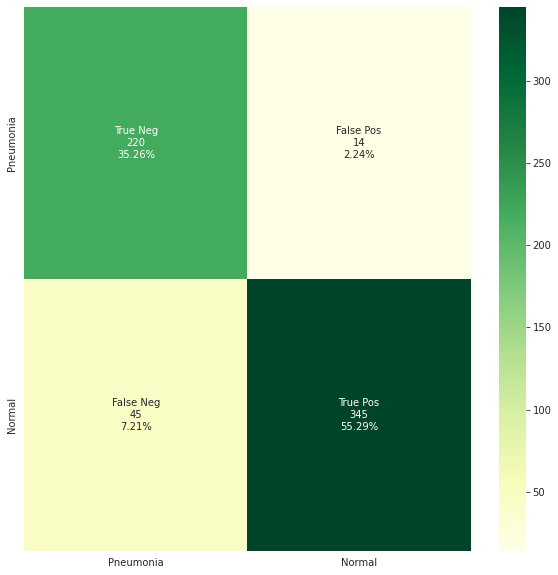

In [65]:


#
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))
classes = ['Pneumonia','Normal']
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
            xticklabels = classes,yticklabels = classes
           )

In [67]:
# store actual class labels and predicted ones in a dataframe

results = pd.DataFrame({'Actual':y_test,'Predicted':pred_labels.flatten()})

incorrect_df = results[results.Actual!=results.Predicted]
incorrect_df.head()


,Actual,Predicted
35,0,1
92,0,1
107,0,1
112,0,1
115,0,1


In [68]:
# manual calculation of of results 
print(f'Accuracy is {round((results.shape[0]-incorrect_df.shape[0])/results.shape[0],2)*100} %')

Accuracy is 91.0 %


In [70]:
#show some examples
correct = np.nonzero(pred_labels == y_test)[0]
incorrect = np.nonzero(pred_labels != y_test)[0]

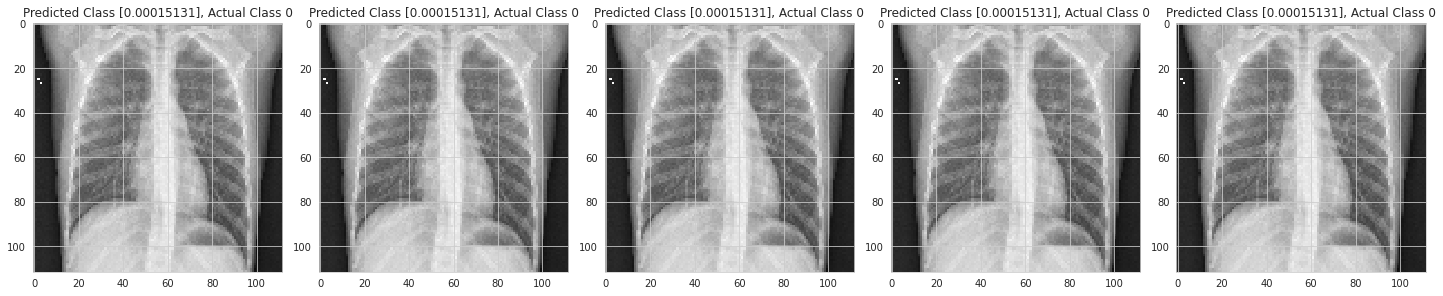

In [71]:
i = 0
figure = plt.figure(figsize= (20,20))
for c in correct[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

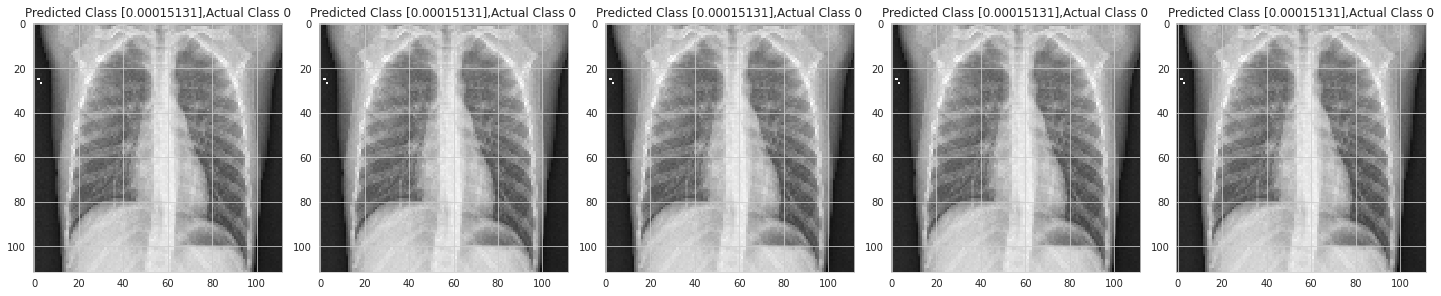

In [72]:
i = 0
figure = plt.figure(figsize= (20,20))
for c in incorrect[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

## Transfer Learning 

### Pre-trained models

Here, we will use a pre-trained model to perform classificatin (Transfer Learning). Various models such as VGG16, XCeption, etc... can be used. In this example, we will use  ResNet152V2 available on the Keras Package. More about this model can be found at [This Link](https://keras.io/api/applications/resnet/#resnet152v2-function). Also notice that these models have been trained using large number of images. More details about pre-trained models with keras and transfer learning can be found [here](https://keras.io/guides/transfer_learning/)


In [73]:
from keras.applications.vgg16 import VGG16 #(if you want to use VG16)
from keras.applications.inception_v3 import InceptionV3


In [74]:

# Notice 1st time this is being run, it will download the weights for the ResNet model
tf.keras.backend.clear_session()

base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)
# freeze the layers
base_model.trainable = False


234545216/234545216 [==============================] - 4s 0us/step


In [75]:
def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_size,img_size, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [76]:

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:

history_tl = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    steps_per_epoch = x_train.shape[0]/batch_size,
                    class_weight = class_weight
                   )


* Check results (similar to previous experiment)
* Compare with previous experiment

<AxesSubplot:>

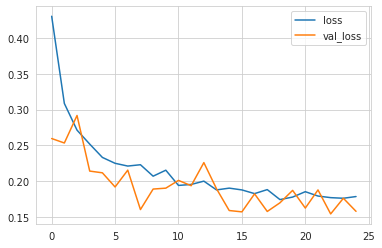

In [78]:
losses = pd.DataFrame(model_pretrained.history.history)
losses[['loss','val_loss']].plot()

<AxesSubplot:>

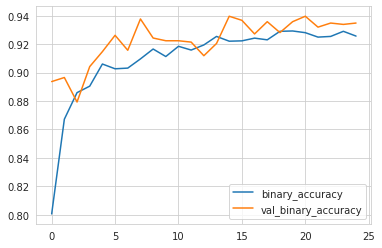

In [79]:
losses[['binary_accuracy','val_binary_accuracy']].plot()


In [80]:

print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 98ms/step - loss: 0.2708 - binary_accuracy: 0.8846
Loss of the model is -  0.27079758048057556
20/20 [==============================] - 2s 80ms/step - loss: 0.2708 - binary_accuracy: 0.8846
Accuracy of the model is -  88.46153616905212 %


In [81]:
predictions = model_pretrained.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)


20/20 [==============================] - 4s 69ms/step


<AxesSubplot:>

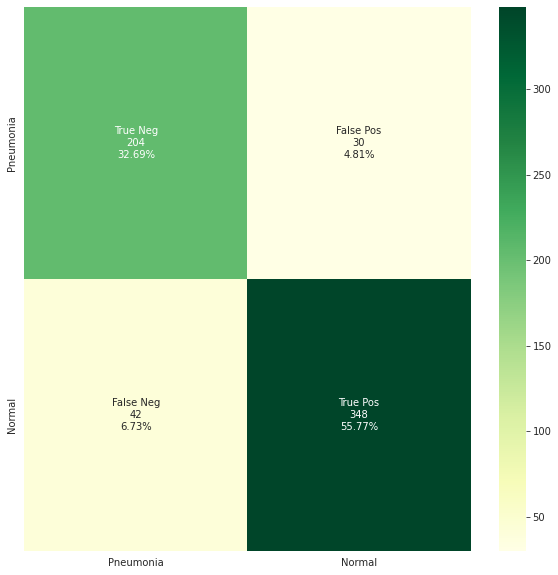

In [82]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
           xticklabels = classes,yticklabels = classes)

In [83]:
cf_matrix

array([[204,  30],
       [ 42, 348]])

### Fine-tuning models

Notice that when we used pre-trained models, we haven't changed the weights, or retrained any of the ResNet layers. Simply put, we have updated the input and output of the models, while keeping all layers of the pre-trained models frozen. Although this is useful, in some cases you need to train some of the layers (update the weights of the model), and this is what is called fine-tuning the models. Here, we are going to unfreeze some layers and retrain. Note also, that we often keep lower layers frozen, because these capture generic features that may be shared with most images. 


In [84]:
#Fine tunning 
base_model.trainable = True

# Retrain the last 10 layers (all lower layers will be kept frozen)
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [85]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=0.000002), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
history_ft = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    steps_per_epoch = x_train.shape[0]/batch_size,
                    class_weight = class_weight
                   )


* Evaluate your model by extracting metrics, store them in a pandas dataframe and reshape it for visualising results


In [87]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 76ms/step - loss: 0.2649 - binary_accuracy: 0.8894
Loss of the model is -  0.2648773193359375
20/20 [==============================] - 2s 74ms/step - loss: 0.2649 - binary_accuracy: 0.8894
Accuracy of the model is -  88.94230723381042 %


In [88]:
predictions = model_pretrained.predict(x_test)
pred_labels= np.where(predictions>0.5, 1, 0)


20/20 [==============================] - 5s 72ms/step


<AxesSubplot:>

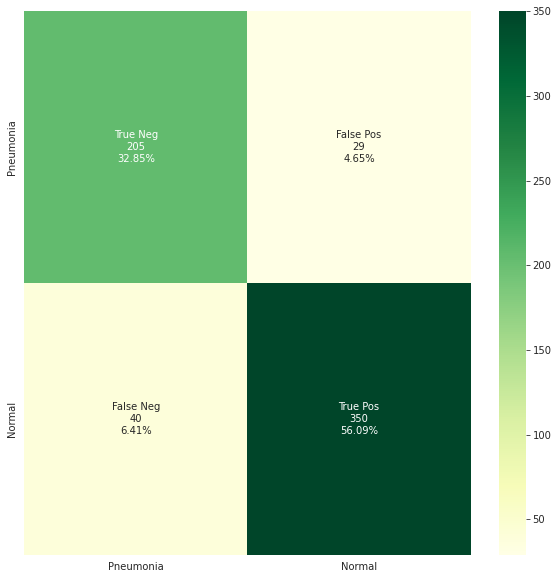

In [89]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
           xticklabels = classes,yticklabels = classes)

## Clean Up 

Run the following cell to terminate the kernel and free memory, before running new experiments: 

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)